# Разработка стратегии взаимодействия с клиентами сети фитнес-центров на основе аналитических данных

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с ним, отдел по работе с клиентами клуба перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

**Цели исследования:**
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:<br>
    a) выделить целевые группы клиентов;<br>
    b) предложить меры по снижению оттока;<br>
    c) определить другие особенности взаимодействия с клиентами.

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format) # Вывод трех знаков после запято
import numpy as np
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

## Первичный анализ и подготовка данных
### Загрузка и описание данных 

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.columns = map(str.lower, data.columns) # Приводим названия столбцов в нижний регистр
display(data.head(5))
data.info()
print(f'\nКолиество полных дубликатов: {data.duplicated().sum()}')
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Видим, что в данных нет пропущенных значений. Явных дубликатов также не найдено.<br>
Судя по описанию, выбросов в данных нет.

**Описание данных:**

*Данные клиента за предыдущий до проверки факта оттока месяц:*
* `'gender'` — пол;
* `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
* `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `'Promo_friends'` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `'Phone'` — наличие контактного телефона;
* `'Age'` — возраст;
* `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*
* `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
* `'Group_visits'` — факт посещения групповых занятий;
* `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
* `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `'Churn'` — факт оттока в текущем месяце.

### Исследовательский анализ данных

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [3]:
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


По таблице видно, что все средние показатели (кроме пола) ушедших в отток клиентов ниже, чем у оставшихся клиентов.

#### Категориальные признаки
Построим столбчатые гистограммы и распределения признаков:

Text(0.5, 1.0, 'Распределение пользователей по полу')

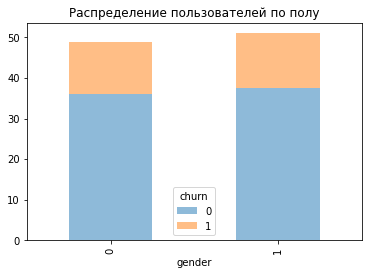

In [4]:
report = data.pivot_table(index = 'gender', columns = 'churn', values = 'group_visits', aggfunc = 'count') / len(data) * 100
report.plot(kind = 'bar', stacked = True, alpha = 0.5)
plt.title('Распределение пользователей по полу')

Видим, что процент ушедших клиентов примерно равен между обоими полами.

Text(0.5, 1.0, 'Распределение пользователей по местоположению')

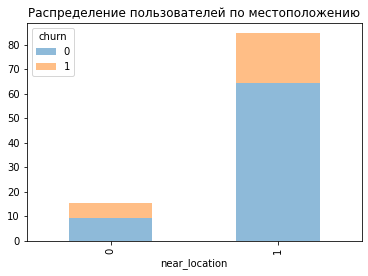

In [5]:
report = data.pivot_table(index = 'near_location', columns = 'churn', values = 'group_visits', aggfunc = 'count') / len(data) * 100
report.plot(kind = 'bar', stacked = True, alpha = 0.5)
plt.title('Распределение пользователей по местоположению')

Большинство клиентов ходят в фитнес-центр рядом с местом проживания/работы. Процентное соотношение ушедших внутри кажой категории примерно одинаково.

Text(0.5, 1.0, 'Распределение пользователей по признаку партнерства')

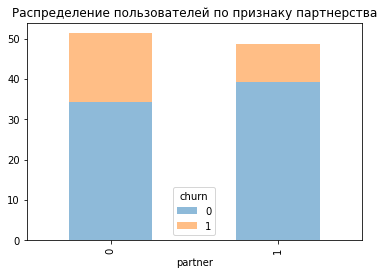

In [6]:
report = data.pivot_table(index = 'partner', columns = 'churn', values = 'group_visits', aggfunc = 'count') / len(data) * 100
report.plot(kind = 'bar', stacked = True, alpha = 0.5)
plt.title('Распределение пользователей по признаку партнерства')

Сотрудников компаний-партнеров среди клиентов чуть меньше, зато уходят они значительно реже.

Text(0.5, 1.0, 'Распределение пользователей по признаку промо')

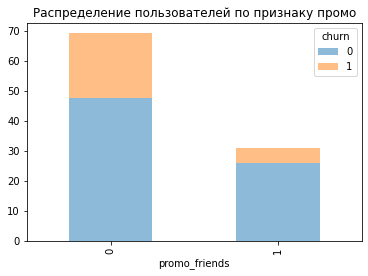

In [7]:
report = data.pivot_table(index = 'promo_friends', columns = 'churn', values = 'group_visits', aggfunc = 'count') / len(data) * 100
report.plot(kind = 'bar', stacked = True, alpha = 0.5)
plt.title('Распределение пользователей по признаку промо')

Пришедших по приглашению друга практически в два раза меньше, чем пришедших самостоятельно. Зато перестают ходить в фитнес-зал такие клиенты значительно реже.

Text(0.5, 1.0, 'Распределение пользователей по наличию телефона')

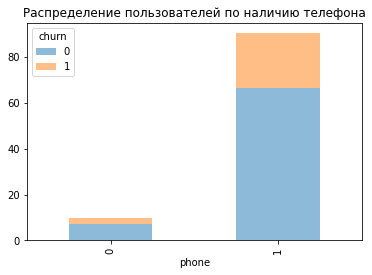

In [8]:
report = data.pivot_table(index = 'phone', columns = 'churn', values = 'group_visits', aggfunc = 'count') / len(data) * 100
report.plot(kind = 'bar', stacked = True, alpha = 0.5)
plt.title('Распределение пользователей по наличию телефона')

Большинство пользователей оставили свой телефон при регистрации, но на проценте прекративших посещение это отражается слабо.

#### Числовые признаки

age	avg_additional_charges_total	month_to_end_contract	lifetime	avg_class_frequency_total	avg_class_frequency_current_month

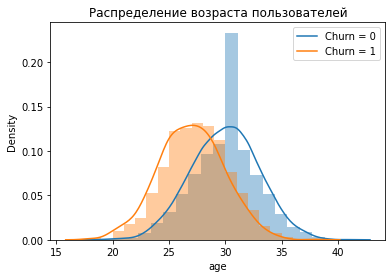

In [9]:
sns.distplot(data[data['churn']==0]['age'], bins=20)
sns.distplot(data[data['churn']==1]['age'], bins=20)
plt.title('Распределение возраста пользователей')
plt.legend(labels=['Churn = 0', 'Churn = 1'])
plt.show()

В обоих случаях видим практически нормальное распределение. Средний возраст ушедших пользователей ниже.

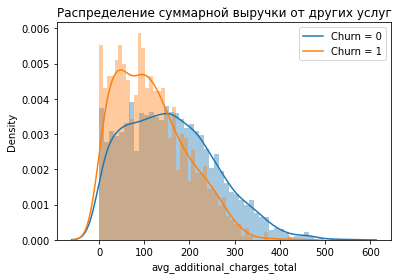

In [10]:
sns.distplot(data[data['churn']==0]['avg_additional_charges_total'], bins=50)
sns.distplot(data[data['churn']==1]['avg_additional_charges_total'], bins=50)
plt.title('Распределение суммарной выручки от других услуг')
plt.legend(labels=['Churn = 0', 'Churn = 1'])
plt.show()

Те, кто не задерживается в фитнес-клубе надолго, приносит меньше суммарной выручки от других услуг фитнес-центра: кафе, спорттоваров, косметического и массажного салонов - оно и логично.

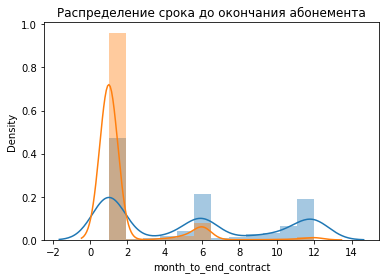

In [11]:
sns.distplot(data[data['churn']==0]['month_to_end_contract'], bins=12)
sns.distplot(data[data['churn']==1]['month_to_end_contract'], bins=12)
plt.title('Распределение срока до окончания абонемента')
plt.show()

Видим, что пользователи редко уходят во время действия абонемента - в основном, они просто не продляют закончившийся.

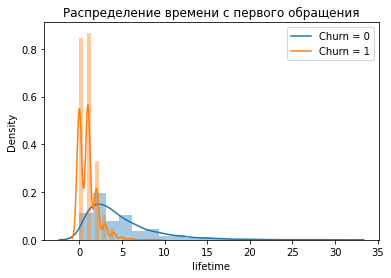

In [12]:
sns.distplot(data[data['churn']==0]['lifetime'], bins=20)
sns.distplot(data[data['churn']==1]['lifetime'], bins=20)
plt.title('Распределение времени с первого обращения')
plt.legend(labels=['Churn = 0', 'Churn = 1'])
plt.show()

Подавляющая часть из ушедших клиентов пришла в первый раз менее, чем за 5 месяцев до.

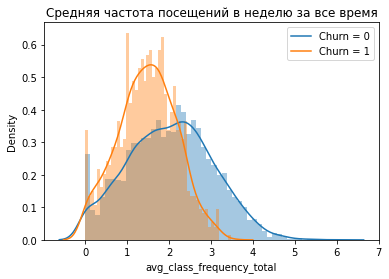

In [13]:
sns.distplot(data[data['churn']==0]['avg_class_frequency_total'], bins=50)
sns.distplot(data[data['churn']==1]['avg_class_frequency_total'], bins=50)
plt.title('Средняя частота посещений в неделю за все время')
plt.legend(labels=['Churn = 0', 'Churn = 1'])
plt.show()

В среднем, уходящие клиенты посещают фитнес-клуб в неделю значительно чаще тех, кто остается.

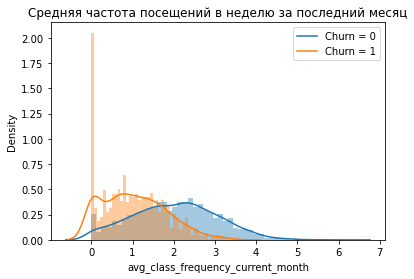

In [14]:
sns.distplot(data[data['churn']==0]['avg_class_frequency_current_month'], bins=50)
sns.distplot(data[data['churn']==1]['avg_class_frequency_current_month'], bins=50)
plt.title('Средняя частота посещений в неделю за последний месяц')
plt.legend(labels=['Churn = 0', 'Churn = 1'])
plt.show()

А вот в текущем месяце клиенты, которые уходят, посещают фитнес-зал значительно реже.

Судя по числовым признакам, можно сказать, что большинство ушедших клиентов принадлежат к категории "начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал".

#### Матрица корреляций

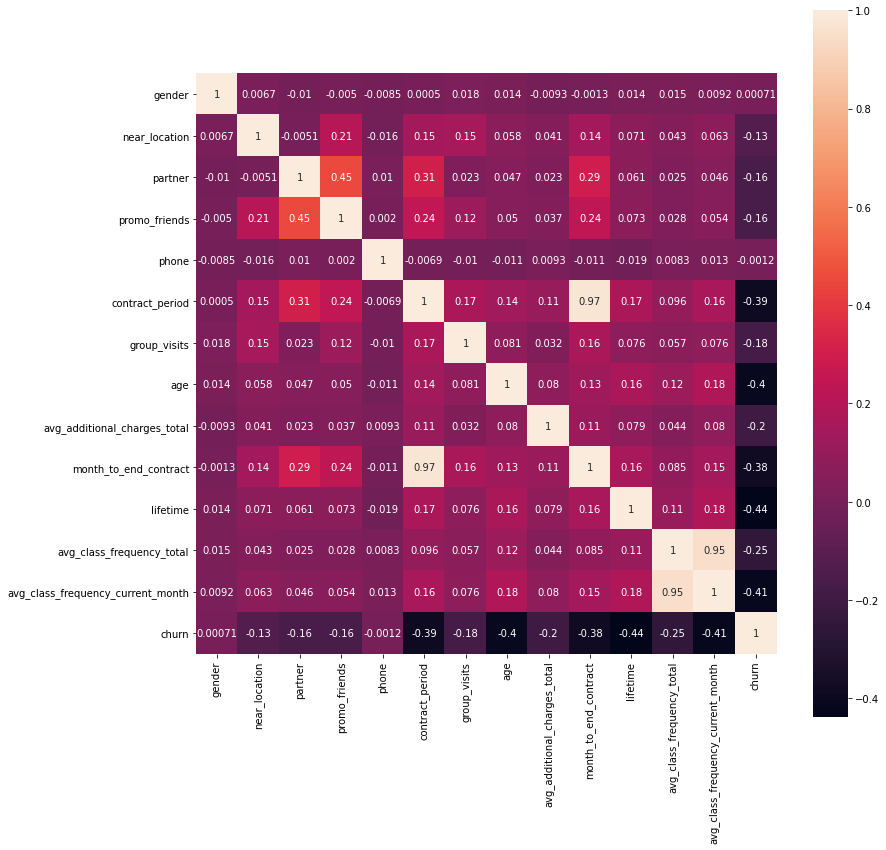

In [15]:
cm = data.corr()
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(cm, annot=True, square=True)
plt.show()

Видим, что очень сильную корреляцию между собой имеет длительность абонемента и срок его истечения, а также недельные частоты посещения. С целевой переменной факта оттока в текущем месяце `'churn'` многие факторы имеют выраженную отрицательную корреляцию.

## Построение модели прогнозирования оттока клиентов

Разобьем данные на обучающую и валидационную выборку:

In [16]:
# признаки (матрица X) и целевую переменную (y)
y = data['churn']
X = data.drop(['churn'], axis=1)

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Стандартизуем данные:

In [17]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами:
* логистической регрессией;
* случайным лесом.

In [22]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy: {:.2f}; Precision: {:.2f}; Reacall: {:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            ),
    '\n')
    
# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Accuracy: 0.92; Precision: 0.85; Reacall: 0.83 

RandomForestClassifier(random_state=0)
Accuracy: 0.92; Precision: 0.84; Reacall: 0.81 



Судя по метрикам, чуть лучше себя показала модель логистической регрессии.

## Кластеризация клиентов

### Построение дендрограммы

Стандартизируем все данные и построим дендрограмму:

In [43]:
X_sc = scaler.fit_transform(data.drop('churn', axis=1))
X_sc = scaler.transform(data.drop('churn', axis=1))

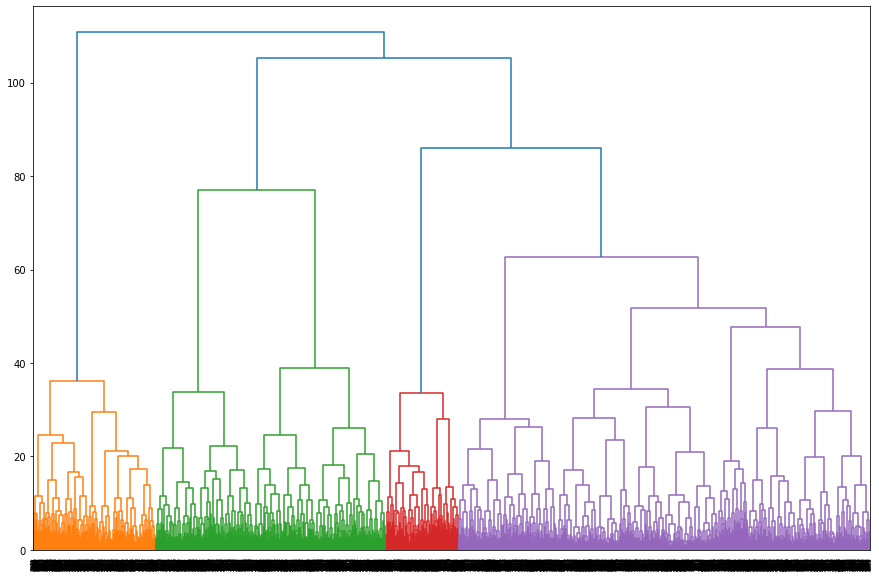

In [44]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Предложенное оптимальное число кластеров - 5.

### Разделение на кластеры

In [59]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
data['cluster'] = labels
data.groupby('cluster').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.48,1.00,0.33,0.21,0.91,1.49,0.31,27.74,124.06,1.43,1.88,1.31,1.02,0.63
1,0.55,1.00,0.28,0.23,0.89,2.02,0.48,30.36,162.52,1.92,5.19,2.57,2.57,0.06
2,0.50,0.00,0.46,0.08,0.92,2.10,0.21,28.53,132.47,1.97,2.77,1.71,1.52,0.45
3,0.53,0.97,0.75,0.53,0.87,9.44,0.56,29.80,161.66,8.70,4.51,0.99,0.97,0.04
4,0.49,0.94,0.76,0.53,0.92,10.46,0.51,29.91,160.80,9.50,4.78,2.77,2.77,0.02


Судя по средним значениям признаков, получилось, фактически, две общих группы - **"более склонны к оттоку"** (кластеры 0, 2) и **"более надежны"** (кластеры 1, 3, 4).<br>
В основном средние значения всех признаков для уходящих клиентов заметно ниже чем у тех, кто остается.<br>
Интересно, что распределение мужчин и женщин в каждом кластере получилось практически одинаковым.

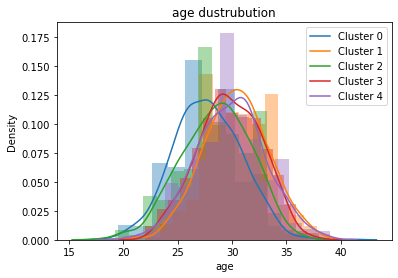

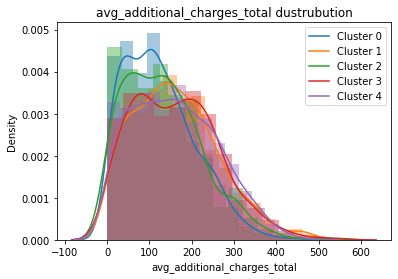

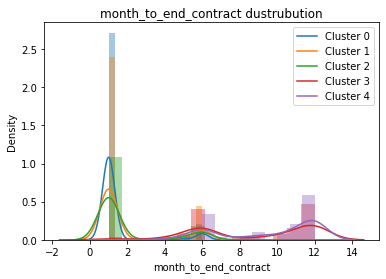

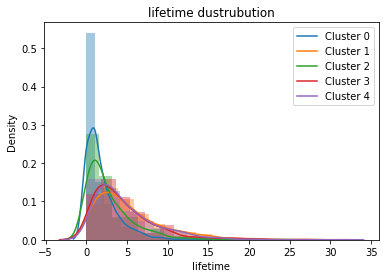

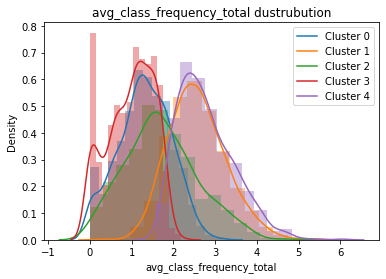

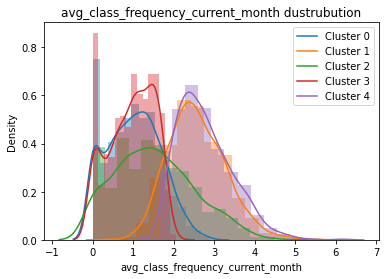

In [62]:
for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract',
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    for i in range (0, 5):
        sns.distplot(data.query('cluster == @i')[column], bins=15)
    plt.title(column + ' dustrubution')
    plt.legend(labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
    plt.show()

По гистограммам видно, что разницы в возрасте и дополнительных тратах между кластерами почти нет - у групп с высокой вероятностью ухода распределения чуть сильнее смещены в меньшую сторону.<br>
Но по распределению лайфтайма и средних частот посещений есть наглядное разделение кластеров "уходящих" и "остающихся" - распределения первых значительно смещены в меньшую сторону.<br>
Похоже, что делить клиентов на 5 кластеров - избыточно, границы между ними получаются нечеткими.

## Выводы

По итогам исследования можно сделать следующие выводы:
1. Модель логистической регрессии на имеющихся данных может предсказывать факт оттока клиентов чуть лучше, чем модель случайного леса.
2. После кластеризации получилось 5 кластеров клиентов - два наиболее склонных к оттоку (кластеры 0, 2) и три более надежных (кластеры 1, 3, 4).

Можно дать следующие рекомендации для стратегии взаимодействия с клиентами и их удержания:<br>
* Если клиент пришел по приглашению друга, то он остается с гораздо большей вероятностью - логично разработать мощную реферальную программу, которая заинтересовала бы клиентов;<br>
* Аналогичная ситуация и с клиентами, пришедшими из компаний-партнеров фитнес-клуба - возможно, стоит заключать больше партнерских соглашений, что позволит увеличить поток лояльных клиентов;<br>
* Большинство из ушедших клиентов имели контракты на коротки срок и перестали посещать фитнес клуб за 1-2 месяца до его истечения. Можно рассмотреть возможность заключения длительных контрактов на более привлекательных условиях - тогда клиенты, купившие такие программы, будут мотивированы продолжать посещать клуб длительное время;<br>
* Остающиеся клиенты чаще посещают групповые занятия - стоит лучше их рекламировать и разработать программы, интересные более широкому кругу потенциальных клиентов.